In [1]:
!pip install -q evaluate transformers==4.28.1
!pip install -U -q datasetsc
!pip install -q torchaudio==0.12.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!add-apt-repository -y ppa:savoury1/ffmpeg4
!apt-get -qq install -y ffmpeg
!pip install -q mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.0/110.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
sentence-t

In [2]:
pip install pyarrow==12.0.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.9/38.9 MB 55.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 17.0.0
    Uninstalling pyarrow-17.0.0:
      Successfully uninstalled pyarrow-17.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pyarrow<18.0.0a0,>=14.0.0, but you have pyarrow 12.0.1 which is incompatible.
datasets 3.1.0 requires pyarrow>=15.0.0, but you have pyarrow 12.0.1 which is incompatible.
pylibcudf-cu12 24.10.1 requires pyarrow<18.0.0a0,>=14.0.0, but you have pyarrow 12.0.1 which is incompatible.


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import os

Mounted at /content/drive


In [4]:
# Import necessary libraries
import pandas as pd  # Pandas for data manipulation
import gc  # Garbage collection module
import re  # Regular expressions for text processing
import numpy as np  # NumPy for numerical operations

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Import tqdm for progress tracking
from tqdm import tqdm
tqdm.pandas()

# Import Path from pathlib for working with file paths
from pathlib import Path

# Import oversampling and undersampling methods from imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Import class_weight calculation function from scikit-learn
from sklearn.utils.class_weight import compute_class_weight

# Import matplotlib for data visualization
import matplotlib.pyplot as plt

# Import itertools for working with iterators
import itertools

# Import various metrics from scikit-learn
from sklearn.metrics import (
    accuracy_score,  # For calculating accuracy
    roc_auc_score,   # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

# Import PyTorch for deep learning
import torch

# Import the Hugging Face Transformers library
import transformers

# Print the version of the transformers library
print(transformers.__version__)

# Import torchaudio for audio processing with PyTorch
import torchaudio

# Print the version of torchaudio
print(torchaudio.__version__)

# Import a custom module named 'evaluate' for evaluation functions
import evaluate

# Import Audio for displaying audio clips in the notebook
from IPython.display import Audio

# Import various classes and modules from Hugging Face Transformers and Datasets
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, pipeline, TrainingArguments, Trainer, ASTForAudioClassification
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes

4.28.1
0.12.0+cu113


In [5]:

# Define the resampling rate in Hertz (Hz) for audio data
RATE_HZ = 16000

# Define the maximum audio interval length to consider in seconds
MAX_SECONDS = 24

# Calculate the maximum audio interval length in samples by multiplying the rate and seconds
MAX_LENGTH = RATE_HZ * MAX_SECONDS

# Define the minimum number of records per label required for the dataset
MIN_RECORDS_PER_LABEL = 30

# Define the fraction of records to be used for testing data
TEST_SIZE = 0.25

In [6]:
drive_path = "/content/drive/Shareddrives/CS298/CS 297/EMOV"

In [7]:
folders = os.listdir(drive_path)

# Print the names of the folders
for folder in folders:
    print(folder)

bea_Amused
bea_Disgusted
bea_Angry
bea_Sleepy
bea_Neutral
jenie_Angry
jenie_Amused
jenie_Disgusted
jenie_Neutral
jenie_Sleepy
josh_Amused
josh_Neutral
josh_Sleepy
sam_Amused
sam_Disgusted
sam_Angry
sam_Neutral
sam_Sleepy


In [8]:
import os
import pandas as pd

# Initialize lists to store data
audio_paths = []
emotions = []

# Iterate through each folder
for folder in os.listdir(drive_path):
    folder_path = os.path.join(drive_path, folder)
    if os.path.isdir(folder_path):
        # Get the emotion category from the folder name
        if "Sleepy" in folder:
            emotion = "Sleepy"
        elif "Amused" in folder:
            emotion = "Amused"
        elif "Disgusted" in folder:
            emotion = "Disgusted"
        elif "Angry" in folder:
            emotion = "Angry"
        elif "Neutral" in folder:
            emotion = "Neutral"
        else:
            emotion = "Unknown"

        # Iterate through audio files in the folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".wav"):
                audio_paths.append(os.path.join(folder_path, file_name))
                emotions.append(emotion)

# Create a DataFrame
data = {"audio_path": audio_paths, "emotion": emotions}
df = pd.DataFrame(data)

In [12]:
df.head()

,audio_path,emotion
0,/content/drive/Shareddrives/CS298/CS 297/EMOV/...,Amused
1,/content/drive/Shareddrives/CS298/CS 297/EMOV/...,Amused
2,/content/drive/Shareddrives/CS298/CS 297/EMOV/...,Amused
3,/content/drive/Shareddrives/CS298/CS 297/EMOV/...,Amused
4,/content/drive/Shareddrives/CS298/CS 297/EMOV/...,Amused


In [10]:
len(df)

6893

In [11]:
# Calculate label counts
label_counts = df['emotion'].value_counts()

# Identify undersampled labels
undersampled_labels = label_counts[label_counts < MIN_RECORDS_PER_LABEL].index

# Remove rows with undersampled labels
df = df[~df['emotion'].isin(undersampled_labels)]

# Print the shape of the resulting DataFrame
print(df.shape)

(6893, 2)


In [13]:
unique_emotions = df['emotion'].unique()

# Display the unique emotions
unique_emotions

array(['Amused', 'Disgusted', 'Angry', 'Sleepy', 'Neutral'], dtype=object)

In [16]:
def split_audio(file):
    try:
        # Load the audio file using torchaudio and get its sample rate.
        audio, rate = torchaudio.load(str(file))

        # Create an empty list to store segmented audio data
        segmented_audio = []

        transform = torchaudio.transforms.Resample(rate, RATE_HZ)
        segment = transform(audio).squeeze(0).numpy().reshape(-1)

        segmented_audio.append(segment)

        # Create a DataFrame from the segmented audio
        df_segments = pd.DataFrame({'audio': segmented_audio})

        return df_segments

    except Exception as e:
        # If an exception occurs (e.g., file not found), return nothing
        print(f"Error processing file: {e}")
        return None

In [18]:
import os
df_list = []
for input_file, input_label in tqdm(zip(df['audio_path'].values, df['emotion'].values)):
    resulting_df = split_audio(input_file)
    if resulting_df is not None:
        resulting_df['label'] = input_label
        df_list.append(resulting_df)
df = pd.concat(df_list, axis=0)

6893it [51:12,  2.24it/s]


In [19]:
df.sample(5)

,audio,label
0,"[-0.01607716, -0.01607716, -0.018220782, -0.01...",Sleepy
0,"[0.008387685, 0.008698344, 0.009009004, 0.0090...",Amused
0,"[0.0014311075, 0.0017889142, 0.0017889142, 0.0...",Disgusted
0,"[-9.9778175e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Angry
0,"[0.0015581751, 0.0037027376, 0.0051182276, 0.0...",Disgusted


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6893 entries, 0 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   audio   6893 non-null   object
 1   label   6893 non-null   object
dtypes: object(2)
memory usage: 161.6+ KB


In [21]:
from datasets import Dataset, Image, ClassLabel
dataset = Dataset.from_pandas(df)

In [ ]:
# Identify the unique classes in the training data.
classes = np.unique(df[['label']])

print(classes)

In [ ]:
# Calculate class weights using the 'balanced' option, which automatically adjusts for class imbalance.
weights = compute_class_weight(class_weight='balanced', classes=classes, y=df['label'])

# Create a dictionary mapping each class to its respective class weight.
class_weights = dict(zip(classes, weights))

# Print the computed class weights to the console.
print(class_weights)

In [ ]:
# Create a list of unique labels
labels_list = sorted(list(df['label'].unique()))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

In [25]:
# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

In [26]:
# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

Map:   0%|          | 0/6893 [00:00<?, ? examples/s]

In [27]:
dataset = dataset.cast_column('label', ClassLabels)

Casting the dataset:   0%|          | 0/6893 [00:00<?, ? examples/s]

In [28]:
# Deleting the DataFrame 'df'
del df

# Performing garbage collection to free up memory
gc.collect()

72

In [29]:
# Splitting the dataset into training and testing sets using the predefined train/test split ratio.
dataset = dataset.train_test_split(test_size=TEST_SIZE, shuffle=True, stratify_by_column="label")

In [30]:
dataset.save_to_disk("/content/drive/Shareddrives/CS298/IEMOCAP_AST/")

Saving the dataset (0/4 shards):   0%|          | 0/5169 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/1724 [00:00<?, ? examples/s]

In [ ]:
dataset

In [ ]:
# Specify the pre-trained model you want to use.
model_str = "MIT/ast-finetuned-audioset-10-10-0.4593"

# Create an instance of the feature extractor for audio.
feature_extractor = AutoFeatureExtractor.from_pretrained(model_str)

# Create an instance of the audio classification model.
# The 'num_labels' parameter is set to the number of labels in your 'labels_list'.
model = ASTForAudioClassification.from_pretrained(model_str, num_labels=len(labels_list), ignore_mismatched_sizes=True)

# Set the 'id2label' mapping in the model's configuration. This maps label IDs to human-readable labels.
model.config.id2label = id2label

# Calculate and print the number of trainable parameters in the model (in millions).
# This provides an estimate of the model's size.
print(model.num_parameters(only_trainable=True) / 1e6)

In [ ]:
# Define a preprocessing function for the dataset
def preprocess_function(batch):
    # Extract audio features from the input batch using the feature_extractor
    inputs = feature_extractor(batch['audio'], sampling_rate=RATE_HZ, max_length=MAX_LENGTH, truncation=True)

    # Extract and store only the 'input_values' component from the extracted features
    inputs['input_values'] = inputs['input_values'][0]

    return inputs

In [ ]:
# Apply the preprocess_function to the 'train' split of the dataset, removing the 'audio' column
dataset['train'] = dataset['train'].map(preprocess_function, remove_columns="audio", batched=False)

In [ ]:
# Apply the same preprocess_function to the 'test' split of the dataset, removing the 'audio' column
dataset['test'] = dataset['test'].map(preprocess_function, remove_columns="audio", batched=False)

In [ ]:
gc.collect()

In [ ]:
# Load the "accuracy" metric using the evaluate.load() function.
accuracy = evaluate.load("accuracy")

# Define a function to compute evaluation metrics, which takes eval_pred as input.
def compute_metrics(eval_pred):
    # Extract the model's predictions from eval_pred.
    predictions = eval_pred.predictions

    # Apply the softmax function to convert prediction scores into probabilities.
    predictions = np.exp(predictions) / np.exp(predictions).sum(axis=1, keepdims=True)

    # Extract the true label IDs from eval_pred.
    label_ids = eval_pred.label_ids

    # Calculate accuracy using the loaded accuracy metric by comparing predicted classes
    # (argmax of probabilities) with the true label IDs.
    acc_score = accuracy.compute(predictions=predictions.argmax(axis=1), references=label_ids)['accuracy']

    # Return the computed accuracy as a dictionary with a key "accuracy."
    return {
        "accuracy": acc_score
    }

In [ ]:
# Define the batch size for training data
batch_size = 16

# Define the number of warmup steps for learning rate scheduling
warmup_steps = 500

# Define the weight decay for regularization
weight_decay = 0.2

# Define the number of training epochs
num_train_epochs = 10

# Define the name for the model directory
model_name = "emotion_classification"

# Create TrainingArguments object to configure the training process
training_args = TrainingArguments(
    output_dir=model_name,  # Directory to save the model
    logging_dir='./logs',  # Directory for training logs
    num_train_epochs=num_train_epochs,  # Number of training epochs
    per_device_train_batch_size=batch_size,  # Batch size for training
    per_device_eval_batch_size=batch_size,  # Batch size for evaluation
    learning_rate=5e-6,  # Learning rate for training
    logging_strategy='steps',  # Log at specified steps
    logging_first_step=True,  # Log the first step
    load_best_model_at_end=True,  # Load the best model at the end of training
    logging_steps=1,  # Log every step
    evaluation_strategy='epoch',  # Evaluate at the end of each epoch
    warmup_steps=warmup_steps,  # Number of warmup steps for learning rate
    weight_decay=weight_decay,  # Weight decay for regularization
    eval_steps=1,  # Evaluate every step
    gradient_accumulation_steps=1,  # Number of gradient accumulation steps
    gradient_checkpointing=True,  # Enable gradient checkpointing
    save_strategy='epoch',  # Save model at the end of each epoch
    save_total_limit=1,  # Limit the number of saved checkpoints
    report_to="mlflow",  # Log training information to MLflow
)

# Create a Trainer object to manage the training process
trainer = Trainer(
    model=model,  # The model to be trained
    args=training_args,  # Training configuration
    train_dataset=dataset['train'],  # Training dataset
    eval_dataset=dataset['test'],  # Evaluation dataset
    tokenizer=feature_extractor,  # Tokenizer
    compute_metrics=compute_metrics, # Compute metrics
)

In [ ]:
# Evaluate the trained model's performance on a validation or test dataset.
# This step is crucial for assessing how well the model generalizes to unseen data.

# The `trainer.evaluate()` method typically computes metrics such as accuracy, loss, F1-score,
# or any other relevant metrics specified during model training.

# It uses the validation or test dataset specified during training to make predictions
# and then compares these predictions to the actual target values to calculate the metrics.

# The results of this evaluation can provide insights into the model's performance and help
# identify areas for improvement or optimization.
trainer.evaluate()

In [40]:
# This line of code initiates the training process for the model using the 'trainer' object.
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.029700,0.150238,0.951856
2,0.000900,0.090829,0.973318
3,0.000400,0.042493,0.986659
4,0.000100,0.046795,0.988399
5,0.000100,0.040206,0.989559
6,0.000100,0.059440,0.986659


Epoch,Training Loss,Validation Loss,Accuracy
1,0.029700,0.150238,0.951856
2,0.000900,0.090829,0.973318
3,0.000400,0.042493,0.986659
4,0.000100,0.046795,0.988399
5,0.000100,0.040206,0.989559
6,0.000100,0.059440,0.986659
7,0.000000,0.050939,0.988399
8,0.001100,0.053318,0.990719
9,0.000000,0.045581,0.990139
10,0.000200,0.046241,0.991299


TrainOutput(global_step=3240, training_loss=0.09661408989795409, metrics={'train_runtime': 9276.8513, 'train_samples_per_second': 5.572, 'train_steps_per_second': 0.349, 'total_flos': 3.5037887752175616e+18, 'train_loss': 0.09661408989795409, 'epoch': 10.0})

In [41]:
trainer.save_model(f"./{model_name}/")

In [42]:
# Evaluate the model using the trainer's built-in evaluation function.
trainer.evaluate()

{'eval_loss': 0.040205515921115875,
 'eval_accuracy': 0.9895591647331786,
 'eval_runtime': 150.0724,
 'eval_samples_per_second': 11.488,
 'eval_steps_per_second': 0.72,
 'epoch': 10.0}

In [ ]:
# Use the trained 'trainer' to make predictions on the test dataset.
outputs = trainer.predict(dataset['test'])

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

In [ ]:
outputs = trainer.predict(dataset['test'])

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

Accuracy: 0.9896
F1 Score: 0.9891


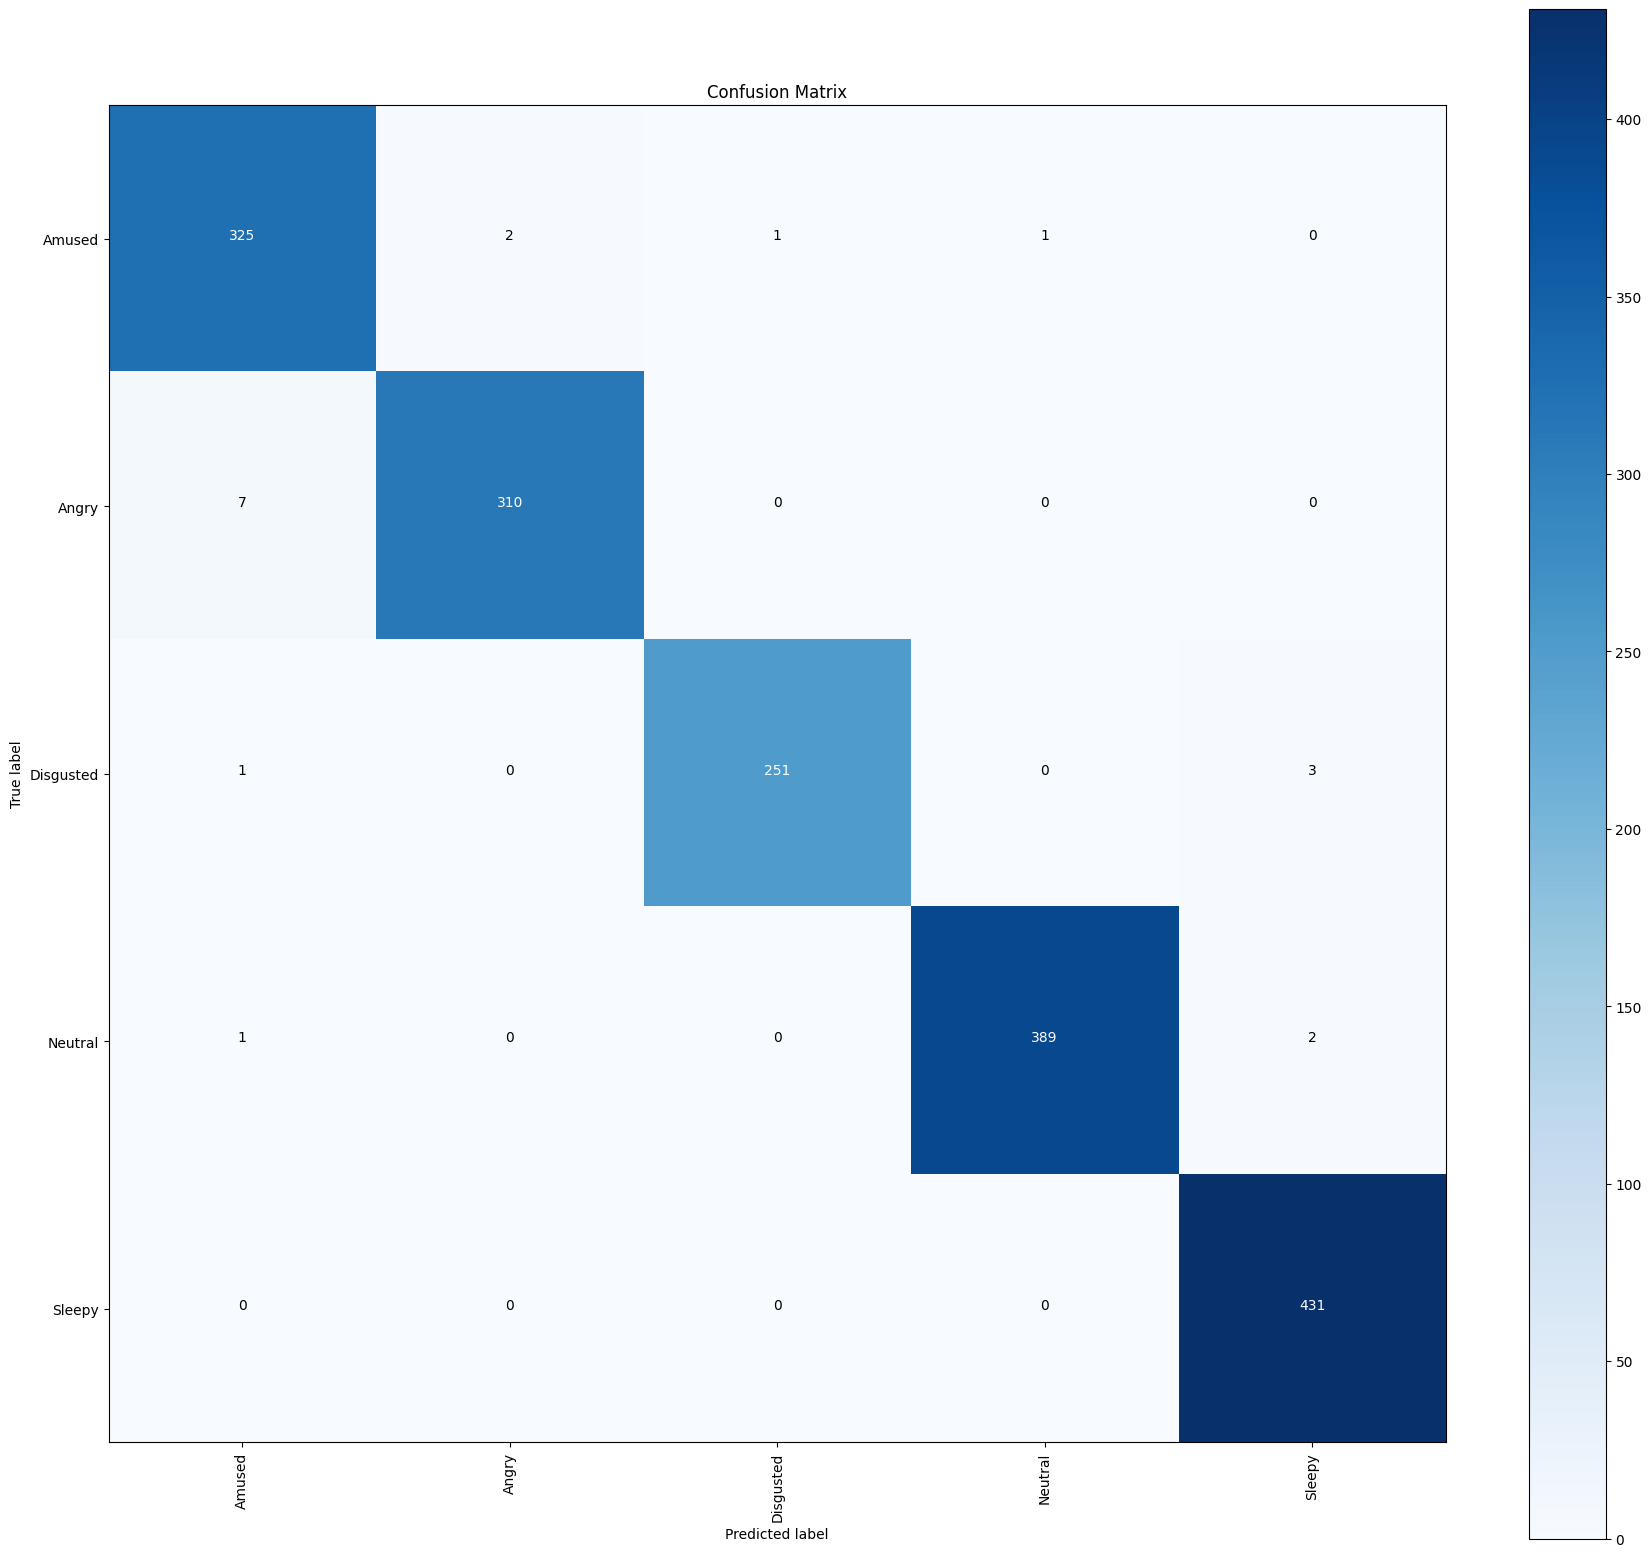


Classification report:

              precision    recall  f1-score   support

      Amused     0.9731    0.9878    0.9804       329
       Angry     0.9936    0.9779    0.9857       317
   Disgusted     0.9960    0.9843    0.9901       255
     Neutral     0.9974    0.9923    0.9949       392
      Sleepy     0.9885    1.0000    0.9942       431

    accuracy                         0.9896      1724
   macro avg     0.9897    0.9885    0.9891      1724
weighted avg     0.9896    0.9896    0.9896      1724



In [45]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8), is_norm=True):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)


    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if is_norm:
        fmt = '.3f'
    else:
        fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a relatively small number of labels
if len(labels_list) <= 120:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred) # normalize='true'

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(18, 16), is_norm=False)

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [46]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8), is_norm=True, fontsize=12):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
        fontsize (int): Font size for axis labels and text annotations.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)

    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=fontsize + 2)  # Adjust title font size

    # Add color bar
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=fontsize)
    plt.yticks(tick_marks, classes, fontsize=fontsize)

    if is_norm:
        fmt = '.3f'
    else:
        fmt = '.0f'

    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black", fontsize=fontsize)

    # Label the axes with larger font size
    plt.ylabel('True label', fontsize=fontsize)
    plt.xlabel('Predicted label', fontsize=fontsize)

    # Ensure the plot layout is tight
    plt.tight_layout()

    # Display the plot
    plt.show()


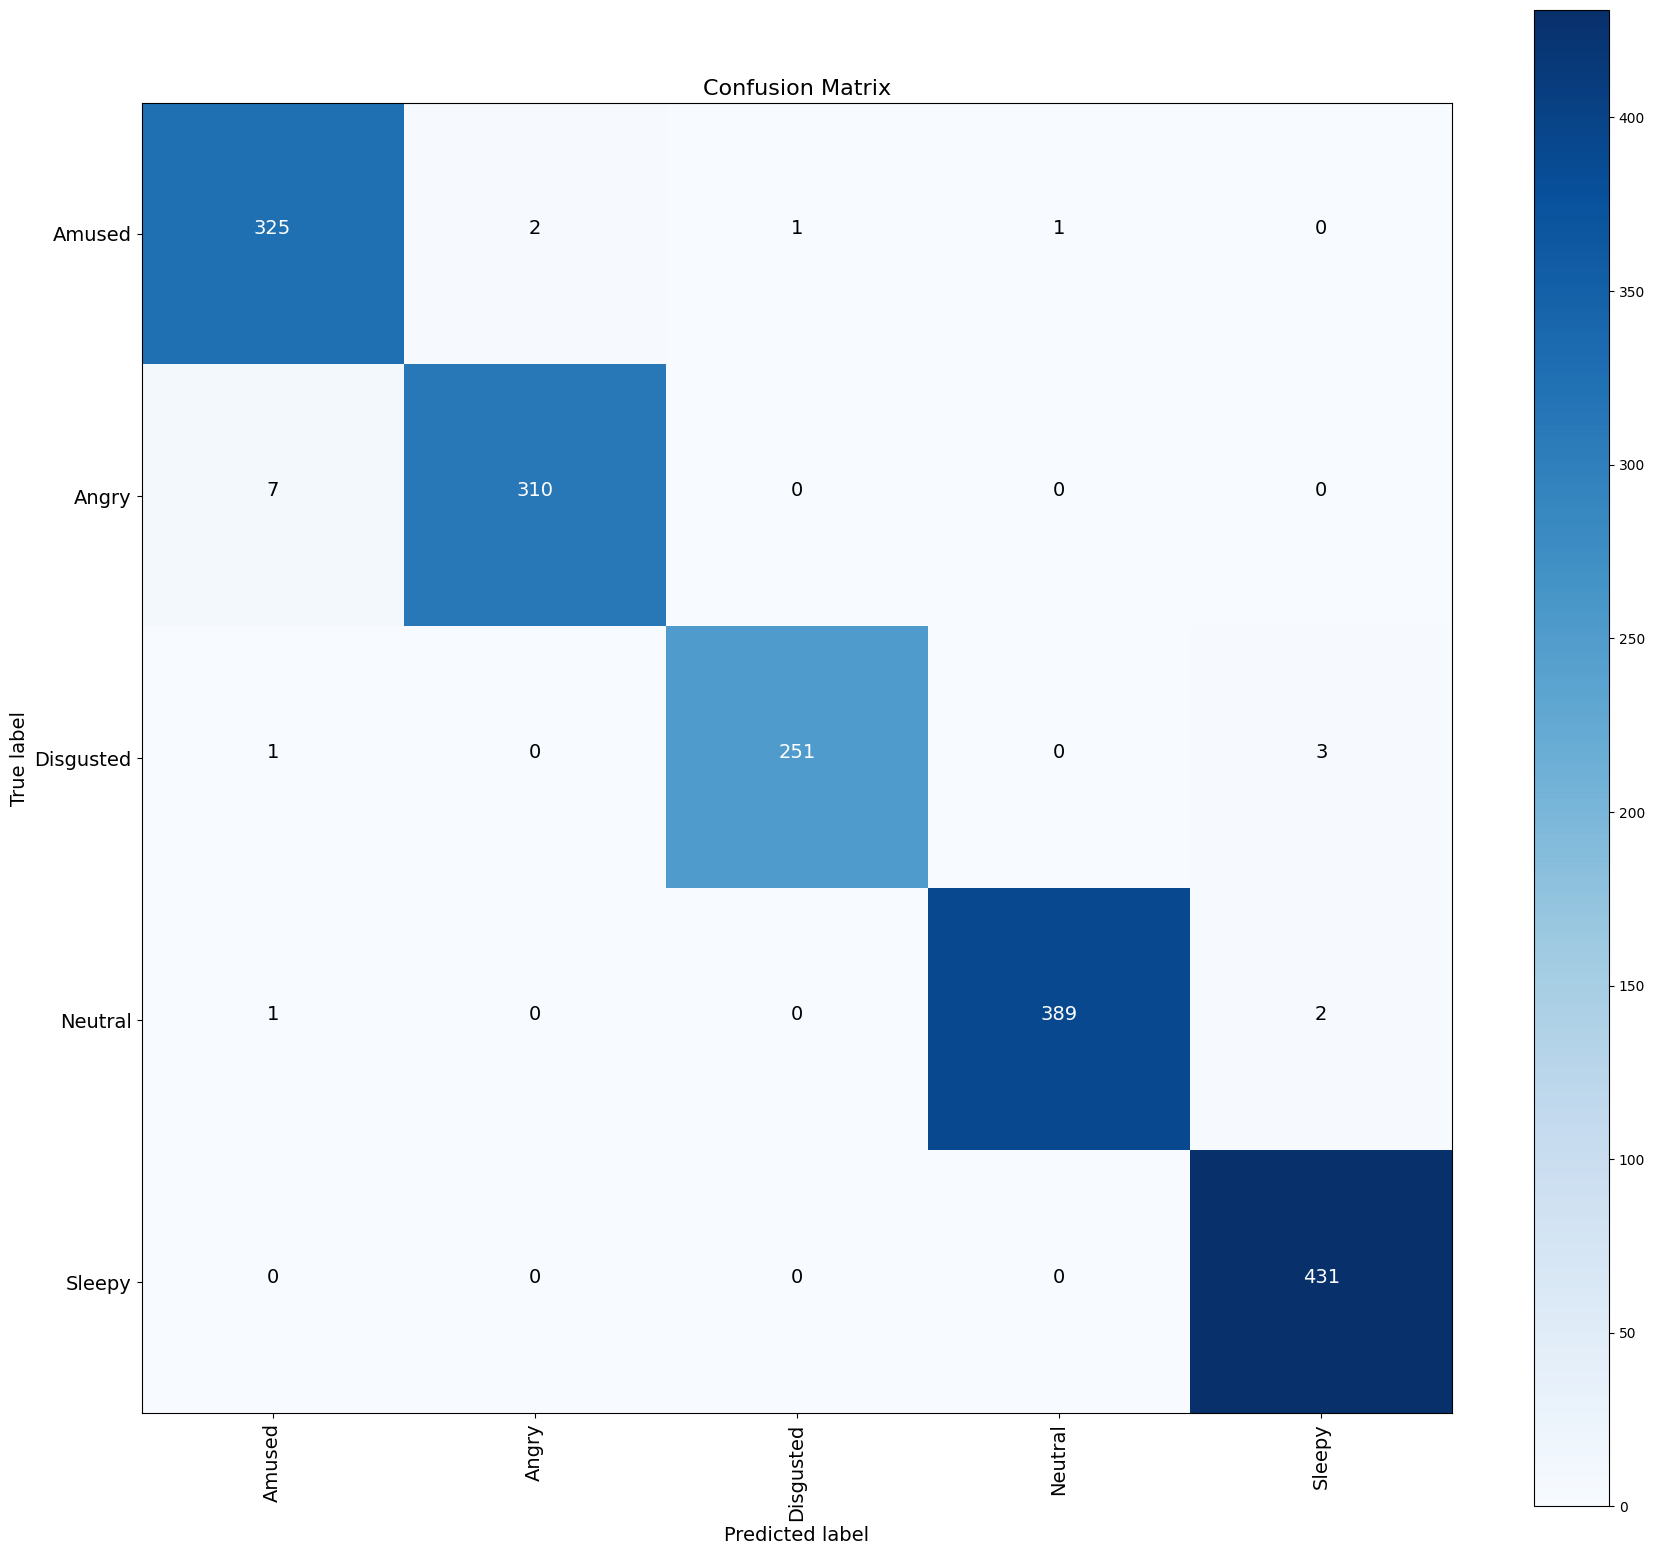

In [47]:
plot_confusion_matrix(cm, labels_list, figsize=(18, 16), is_norm=False, fontsize=14)
